# ECG Prediction using PPG signals

In [1]:
import os
import sys
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Add the parent directory (i.e. transformer, means parent directory of 'scripts' and 'notebooks') to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import the function
from scripts.basic_functions import *

In [2]:
## Data Loader
def data_loader(subject, action):
    '''
    Automate input reading: select subject, action
    Read in csv file
    '''
    df_data_ppg = pd.read_csv(
        '../data/Finger/csv/s'+ str(subject) + '_' + str(action) + '.csv',
        sep=',',           # specify delimiter (default is ',')
        header=0,          # row number to use as column names (0 means the first row)
        na_values=['NA', ''],  # specify which values should be considered NaN
    )
    return df_data_ppg

In [3]:
# Sample data and sampling frequency
fs = 500  

# Define bandpass range for PPG 
lowcut = 0.4
highcut = 10

df_data = data_loader(subject=10, action='sit')
df_ecg = df_data.iloc[:,[1]]
df_ecg['ecg'] = bandpass_filter(df_ecg['ecg'], lowcut, highcut, fs, order=4)
print(df_ecg)
df_ppg = df_data.iloc[:,[6,7,8]]
print(df_ppg)
df_ppg['pleth_4'] = bandpass_filter(df_data['pleth_4'], lowcut, highcut, fs, order=4)
df_ppg['pleth_5'] = bandpass_filter(df_data['pleth_5'], lowcut, highcut, fs, order=4)
df_ppg['pleth_6'] = bandpass_filter(df_data['pleth_6'], lowcut, highcut, fs, order=4)
df_ppg

               ecg
0      -988.770885
1      -955.068843
2      -921.391817
3      -887.849662
4      -854.547269
...            ...
242838 -994.974026
242839 -901.869575
242840 -812.295776
242841 -726.706888
242842 -645.500397

[242843 rows x 1 columns]
        pleth_4  pleth_5  pleth_6
0         90569    99964     6084
1         90569    99964     6084
2         90571    99960     6082
3         90580    99967     6084
4         90579    99948     6082
...         ...      ...      ...
242838    90701   100168     6304
242839    90701   100175     6303
242840    90711   100180     6286
242841    90711   100180     6286
242842    90710   100183     6300

[242843 rows x 3 columns]


/var/folders/ft/8d1p935913j1_tk94srvt2lm0000gn/T/ipykernel_7856/1457531308.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ecg['ecg'] = bandpass_filter(df_ecg['ecg'], lowcut, highcut, fs, order=4)
/var/folders/ft/8d1p935913j1_tk94srvt2lm0000gn/T/ipykernel_7856/1457531308.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppg['pleth_4'] = bandpass_filter(df_data['pleth_4'], lowcut, highcut, fs, order=4)
/var/folders/ft/8d1p935913j1_tk94srvt2lm0000gn/T/ipykernel_7856/1457531308.py:15: SettingWith

,pleth_4,pleth_5,pleth_6
0,-3.525530,-8.256472,-12.250164
1,-2.936302,-8.629138,-12.882595
2,-2.347811,-8.993880,-13.517396
3,-1.763572,-9.347540,-14.152465
4,-1.187063,-9.687161,-14.785762
...,...,...,...
242838,-3.120506,-0.011858,2.887280
242839,-2.835171,-0.001437,2.653661
242840,-2.558626,0.006850,2.422833
242841,-2.292837,0.013345,2.196585


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
ecg_tensor = torch.tensor(df_ecg['ecg'].values).float().unsqueeze(-1)

In [6]:
# Normalize ppg signals
scaler = MinMaxScaler()
ppg_normalized = scaler.fit_transform(df_ppg)
ppg_tensor = torch.tensor(ppg_normalized, dtype=torch.float32)
ppg_tensor

tensor([[0.3532, 0.3321, 0.3049],
        [0.3593, 0.3304, 0.3018],
        [0.3654, 0.3287, 0.2987],
        ...,
        [0.3632, 0.3707, 0.3763],
        [0.3660, 0.3707, 0.3752],
        [0.3686, 0.3707, 0.3741]])

In [ ]:
# Create sequences and slice ecg_tensor
subset = 1099
target_sequence = ecg_tensor[:subset-99]

def create_sequences(ppg_data, ecg_data, sequence_length):
    sequences_ppg = []
    sequences_ecg = []
    for i in range(len(ppg_data) - sequence_length + 1):  ### change stepsize to 5, 10, 20?
        ### sequences are shifted by 1 timestamp / sample per sequence! 
        seq_ppg = ppg_data[i:i + sequence_length]
        seq_ecg = ecg_data[i:i + sequence_length]
        sequences_ppg.append(seq_ppg)
        sequences_ecg.append(seq_ecg)
    return torch.stack(sequences_ppg), torch.stack(sequences_ecg)

sequence_length = 100  # Example: sequences_ppg of 100 timesteps
input_sequences, target_sequence = create_sequences(ppg_tensor[:subset], ecg_tensor[:subset], sequence_length)

print(input_sequences.size())
print(target_sequence.size())

torch.Size([1000, 100, 3])
torch.Size([1000, 100, 1])


In [8]:
x_data = input_sequences  # Shape (1000, 100, 3) (PPG data)
y_data = target_sequence  # Shape (1000, 1) (ECG data)

# Check if the shape of both is aligned
assert x_data.shape[0] == y_data.shape[0], "Number of samples do not match!"

In [43]:
y_data

tensor([[[ -988.7709],
         [ -955.0688],
         [ -921.3918],
         ...,
         [ -320.9736],
         [ -326.2130],
         [ -331.6090]],

        [[ -955.0688],
         [ -921.3918],
         [ -887.8497],
         ...,
         [ -326.2130],
         [ -331.6090],
         [ -337.0741]],

        [[ -921.3918],
         [ -887.8497],
         [ -854.5472],
         ...,
         [ -331.6090],
         [ -337.0741],
         [ -342.5169]],

        ...,

        [[-1212.8298],
         [-1144.7670],
         [-1067.2340],
         ...,
         [ 9368.1836],
         [ 8724.7617],
         [ 8027.0303]],

        [[-1144.7670],
         [-1067.2340],
         [ -980.0984],
         ...,
         [ 8724.7617],
         [ 8027.0303],
         [ 7283.7388]],

        [[-1067.2340],
         [ -980.0984],
         [ -883.3381],
         ...,
         [ 8027.0303],
         [ 7283.7388],
         [ 6504.0737]]])

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len = 100):
        super().__init__()  # new version of: super(PositionalEncodingLayer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        print("Shape of pe:", pe.size())
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Shape: [max_len, 1], Arange: Returns a 1-D tensor from start to stop, Unsqueeze: Returns a new tensor with a dimension of size one inserted at the specified position
        print("Shape of position:", position.size())
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)) # Shape: [d_model // 2]
        print("Shape of div_term", div_term.size())
        
        # Expand div_term to match the shape of position
        div_term = div_term.unsqueeze(0)  # Shape: [1, d_model // 2]
        div_term = div_term.expand(max_len, -1)  # Shape: [max_len, d_model // 2]

        # Make sure div_term is of shape [max_len, d_model] to broadcast properly
        div_term_full = torch.zeros(max_len, d_model)
        div_term_full[:, 0::2] = div_term  # Fill every other column with div_term
        print("Corrected shape of div_term", div_term.size())

        pe[:, 0::2] = torch.sin(position * div_term_full[:, 0::2])  # Sine for even indices
        pe[:, 1::2] = torch.cos(position * div_term_full[:, 1::2])  # Cosine for odd indices
        # pe = pe.unsqueeze(0)
        # x = x + pe[:, :x.size(1)]
        
        self.pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        
    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1), :]
        return x



In [10]:
d_model = input_sequences.shape[2]  # Number of features
positional_encoding = PositionalEncoding(d_model)
pe_input_seq = positional_encoding(input_sequences)
print("Output shape:", pe_input_seq.size())
print("sample of pe:", pe_input_seq[0])

Shape of pe: torch.Size([100, 3])
Shape of position: torch.Size([100, 1])
Shape of div_term torch.Size([2])
Corrected shape of div_term torch.Size([100, 2])
Output shape: torch.Size([1000, 100, 3])
sample of pe: tensor([[ 0.3532,  1.3321,  0.3049],
        [ 1.2008,  1.3304,  0.3040],
        [ 1.2747,  1.3287,  0.3030],
        [ 0.5126,  1.3270,  0.3021],
        [-0.3793,  1.3254,  0.3012],
        [-0.5755,  1.3239,  0.3003],
        [ 0.1097,  1.3225,  0.2994],
        [ 1.0517,  1.3212,  0.2985],
        [ 1.3894,  1.3200,  0.2977],
        [ 0.8172,  1.3189,  0.2970],
        [-0.1341,  1.3179,  0.2963],
        [-0.5855,  1.3170,  0.2956],
        [-0.1179,  1.3163,  0.2951],
        [ 0.8428,  1.3156,  0.2946],
        [ 1.4167,  1.3151,  0.2942],
        [ 1.0796,  1.3147,  0.2939],
        [ 0.1442,  1.3143,  0.2936],
        [-0.5268,  1.3141,  0.2935],
        [-0.3144,  1.3139,  0.2934],
        [ 0.5881,  1.3138,  0.2935],
        [ 1.3525,  1.3137,  0.2936],
        [ 1

In [11]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=4, d_model=32, nhead=4, dim_feedforward=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src) * torch.sqrt(torch.tensor(src.size(-1), dtype=torch.float32))
        src = self.positional_encoding(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output)
        return output

In [12]:
# Split ratio 
train_ratio = 0.8
train_size = int(train_ratio * x_data.size(0))  # Number of training samples
val_size = x_data.size(0) - train_size          # Number of validation samples

# Option 1: Manual slicing (if shuffle is not needed)
X_train, X_val = x_data[:train_size], x_data[train_size:]
y_train, y_val = y_data[:train_size], y_data[train_size:]

# Print shapes for verification
print(f"x_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


x_train shape: torch.Size([800, 100, 3]), y_train shape: torch.Size([800, 100, 1])
x_val shape: torch.Size([200, 100, 3]), y_val shape: torch.Size([200, 100, 1])


In [13]:
# Model initialization 
d_model = 32  # Embedding dimension
input_dim = 3  # 3 PPG signals (red, green, IR)
output_dim = 1  # 1 ECG target per time step
nhead = 8  # Attention heads
num_layers = 4  # Number of transformer layers
batch_size = 32  # Batch size


model = TransformerTimeSeries(input_dim=input_dim, output_dim=output_dim, d_model=d_model, nhead=nhead, num_layers=num_layers) # Replace 1 with your output features
output = model(pe_input_seq)

# Loss function: Mean Squared Error for regression tasks
loss_fn = nn.MSELoss()

# Optimizer: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  # Number of epochs to train

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    # Initialize running loss
    running_loss = 0.0

    # Iterate through the training data in batches
    for i in range(0, len(X_train), batch_size):
        # Get the current batch
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        predictions = model(batch_X)

        # Calculate loss (MSE between predicted ECG and actual ECG)
        loss = loss_fn(predictions, batch_y)

        # Backward pass (compute gradients)
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    avg_loss = running_loss / len(X_train)
    
    # Validation metrics (optional but useful)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = loss_fn(val_predictions, y_val).item()
        val_rmse = torch.sqrt(torch.tensor(val_loss))
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Val RMSE: {val_rmse:.4f}")


Shape of pe: torch.Size([100, 32])
Shape of position: torch.Size([100, 1])
Shape of div_term torch.Size([16])
Corrected shape of div_term torch.Size([100, 16])


/Users/andrifurrer/anaconda3/envs/transformer/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10 | Train Loss: 389001.2900 | Val RMSE: 2376.5273
Epoch 2/10 | Train Loss: 388985.5648 | Val RMSE: 2376.6230
Epoch 3/10 | Train Loss: 388969.8724 | Val RMSE: 2376.6709
Epoch 4/10 | Train Loss: 388950.9891 | Val RMSE: 2376.6318
Epoch 5/10 | Train Loss: 388928.7616 | Val RMSE: 2376.4727
Epoch 6/10 | Train Loss: 388902.0158 | Val RMSE: 2376.1885
Epoch 7/10 | Train Loss: 388871.1972 | Val RMSE: 2375.8279
Epoch 8/10 | Train Loss: 388835.9431 | Val RMSE: 2375.4656
Epoch 9/10 | Train Loss: 388796.8254 | Val RMSE: 2375.1028
Epoch 10/10 | Train Loss: 388758.9793 | Val RMSE: 2374.7815


In [23]:
torch.save(model.state_dict(), '../models/transformer_m1_ecg_model.pth')

In [16]:
val_predictions.size()

torch.Size([200, 100, 1])

In [17]:
ecg_predictions = val_predictions.squeeze(-1)
ecg_predictions.size()

torch.Size([200, 100])

20000
20000


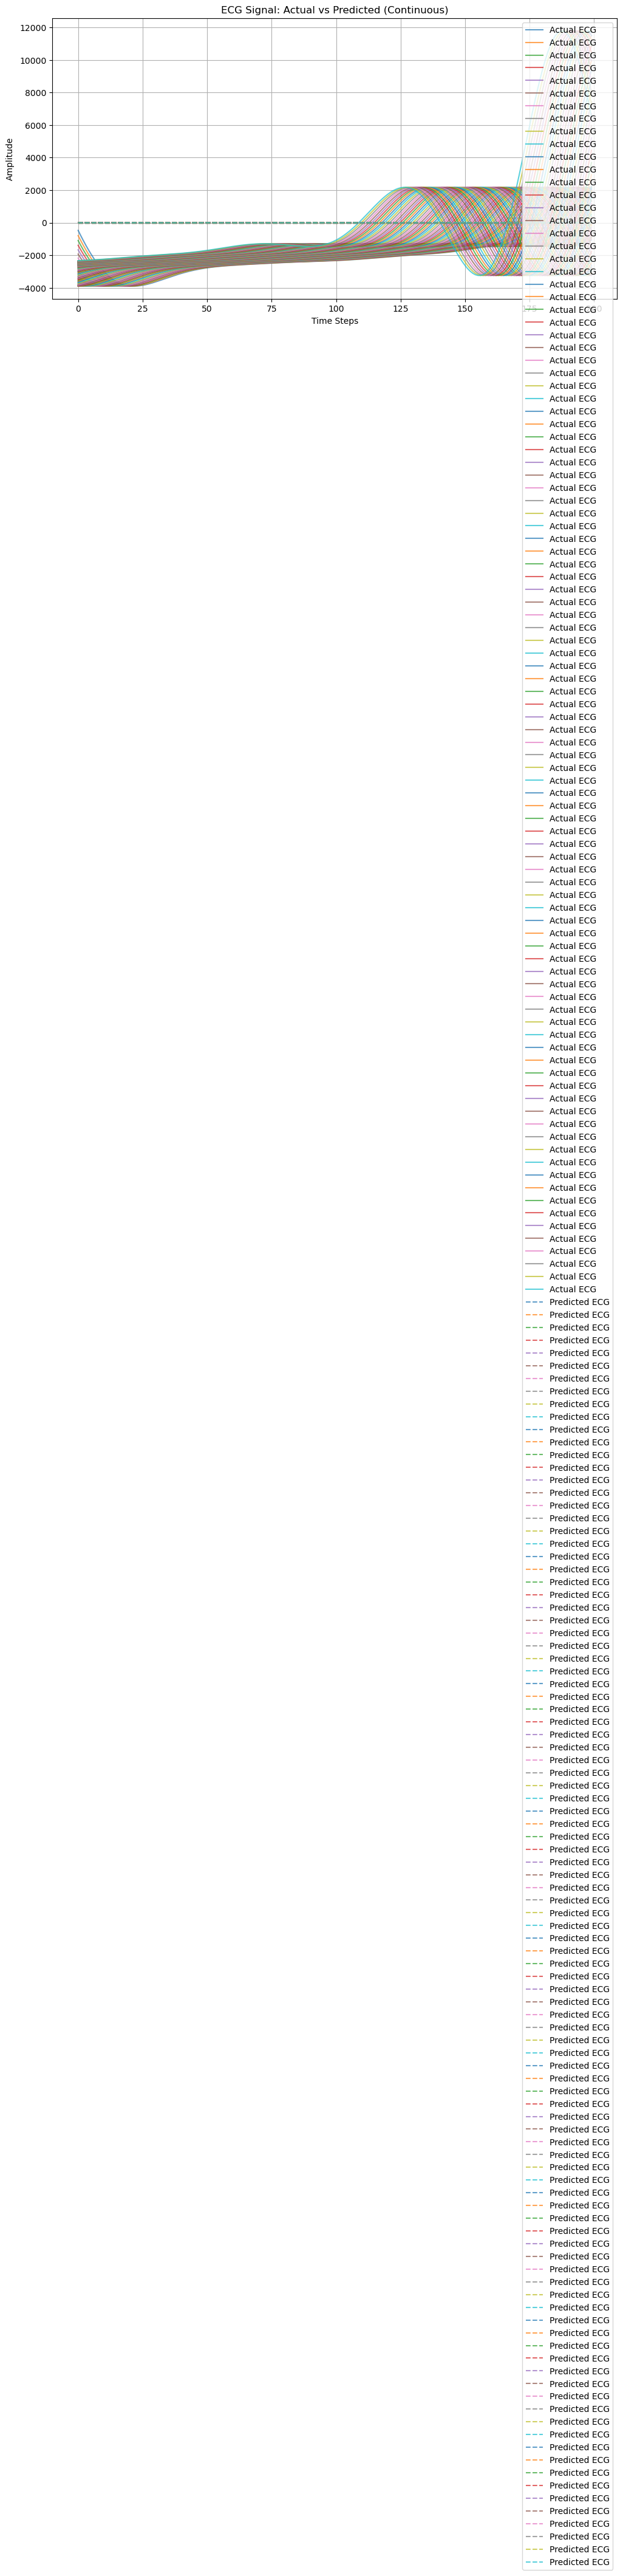

In [50]:
# Convert tensors to numpy arrays if they aren't already
actual_ecg = y_val.squeeze(-1).numpy() if y_val.dim() > 2 else y_val.numpy()
predicted_ecg = ecg_predictions.squeeze(-1).numpy() if ecg_predictions.dim() > 2 else ecg_predictions.numpy()
print(actual_ecg.size)
print(predicted_ecg.size)
# Plot the continuous signal
plt.figure(figsize=(12, 6))
plt.plot(actual_ecg[:200], label='Actual ECG', alpha=0.7, linestyle='-', linewidth=1.5)
plt.plot(predicted_ecg[:200], label='Predicted ECG', alpha=0.7, linestyle='--', linewidth=1.5)
plt.title('ECG Signal: Actual vs Predicted (Continuous)')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
print("Shape of actual_ecg:", actual_ecg.shape)
print("Shape of predicted_ecg:", predicted_ecg.shape)


Shape of actual_ecg: (200, 100)
Shape of predicted_ecg: (200, 100)


In [53]:
print("First 10 Actual ECG Values:", actual_ecg[:10])



First 10 Actual ECG Values: [[ -471.04428  -787.94684 -1093.3647  -1385.9954  -1664.6824  -1928.4221
  -2176.3696  -2407.8406  -2622.3145  -2819.4314  -2998.991   -3160.9478
  -3305.4036  -3432.6008  -3542.9133  -3636.8342  -3714.966   -3778.0068
  -3826.7383  -3862.0115  -3884.7332  -3895.8533  -3896.3506  -3887.2207
  -3869.4644  -3844.0757  -3812.0327  -3774.287   -3731.7578  -3685.3223
  -3635.8115  -3584.0046  -3530.6255  -3476.3386  -3421.748   -3367.3958
  -3313.761   -3261.2612  -3210.252   -3161.0298  -3113.8337  -3068.8481
  -3026.2065  -2985.9944  -2948.2546  -2912.99    -2880.1692  -2849.7312
  -2821.589   -2795.635   -2771.745   -2749.783   -2729.6038  -2711.058
  -2693.995   -2678.2651  -2663.7224  -2650.2268  -2637.6458  -2625.855
  -2614.7395  -2604.1946  -2594.1262  -2584.4497  -2575.0923  -2565.9905
  -2557.0913  -2548.3516  -2539.7375  -2531.224   -2522.7944  -2514.4392
  -2506.1555  -2497.9468  -2489.8208  -2481.7896  -2473.8682  -2466.0735
  -2458.4226  -2450.933  

In [54]:
print("First 10 Predicted ECG Values:", predicted_ecg[:10])

First 10 Predicted ECG Values: [[-2.7601705 -2.8123732 -2.8316538 -2.8268998 -2.780655  -2.7243633
  -2.696869  -2.6670952 -2.6211903 -2.5784707 -2.5311131 -2.5581656
  -2.682515  -2.7503853 -2.7404768 -2.6910343 -2.4969223 -1.8560973
  -1.3451253 -1.4842072 -1.8092002 -2.0542717 -2.1901903 -2.252674
  -2.3814945 -2.5211911 -2.5610893 -2.5031042 -2.3153107 -1.7334265
  -1.1245368 -1.3084247 -1.9351815 -2.3248894 -2.5626245 -2.6411014
  -2.6595213 -2.7255816 -2.7716284 -2.7525241 -2.6897247 -2.593935
  -2.5233512 -2.5797987 -2.7020404 -2.7878656 -2.8234708 -2.8207808
  -2.781927  -2.7493138 -2.7381213 -2.6915464 -2.5692399 -2.3836298
  -2.1851783 -2.2094202 -2.498942  -2.6865153 -2.7355711 -2.7302694
  -2.6461046 -2.4651158 -2.3315482 -2.2904346 -2.2722244 -2.2948725
  -2.3471954 -2.4175732 -2.5537467 -2.7057793 -2.7605503 -2.739357
  -2.6173313 -2.1575854 -1.5521212 -1.5674264 -2.0341613 -2.4114163
  -2.631508  -2.713461  -2.734589  -2.775833  -2.804691  -2.777114
  -2.6920497 -2.52879

In [39]:
print(actual_ecg[:200][0])

[ -471.04428  -787.94684 -1093.3647  -1385.9954  -1664.6824  -1928.4221
 -2176.3696  -2407.8406  -2622.3145  -2819.4314  -2998.991   -3160.9478
 -3305.4036  -3432.6008  -3542.9133  -3636.8342  -3714.966   -3778.0068
 -3826.7383  -3862.0115  -3884.7332  -3895.8533  -3896.3506  -3887.2207
 -3869.4644  -3844.0757  -3812.0327  -3774.287   -3731.7578  -3685.3223
 -3635.8115  -3584.0046  -3530.6255  -3476.3386  -3421.748   -3367.3958
 -3313.761   -3261.2612  -3210.252   -3161.0298  -3113.8337  -3068.8481
 -3026.2065  -2985.9944  -2948.2546  -2912.99    -2880.1692  -2849.7312
 -2821.589   -2795.635   -2771.745   -2749.783   -2729.6038  -2711.058
 -2693.995   -2678.2651  -2663.7224  -2650.2268  -2637.6458  -2625.855
 -2614.7395  -2604.1946  -2594.1262  -2584.4497  -2575.0923  -2565.9905
 -2557.0913  -2548.3516  -2539.7375  -2531.224   -2522.7944  -2514.4392
 -2506.1555  -2497.9468  -2489.8208  -2481.7896  -2473.8682  -2466.0735
 -2458.4226  -2450.933   -2443.621   -2436.501   -2429.5833  -2422

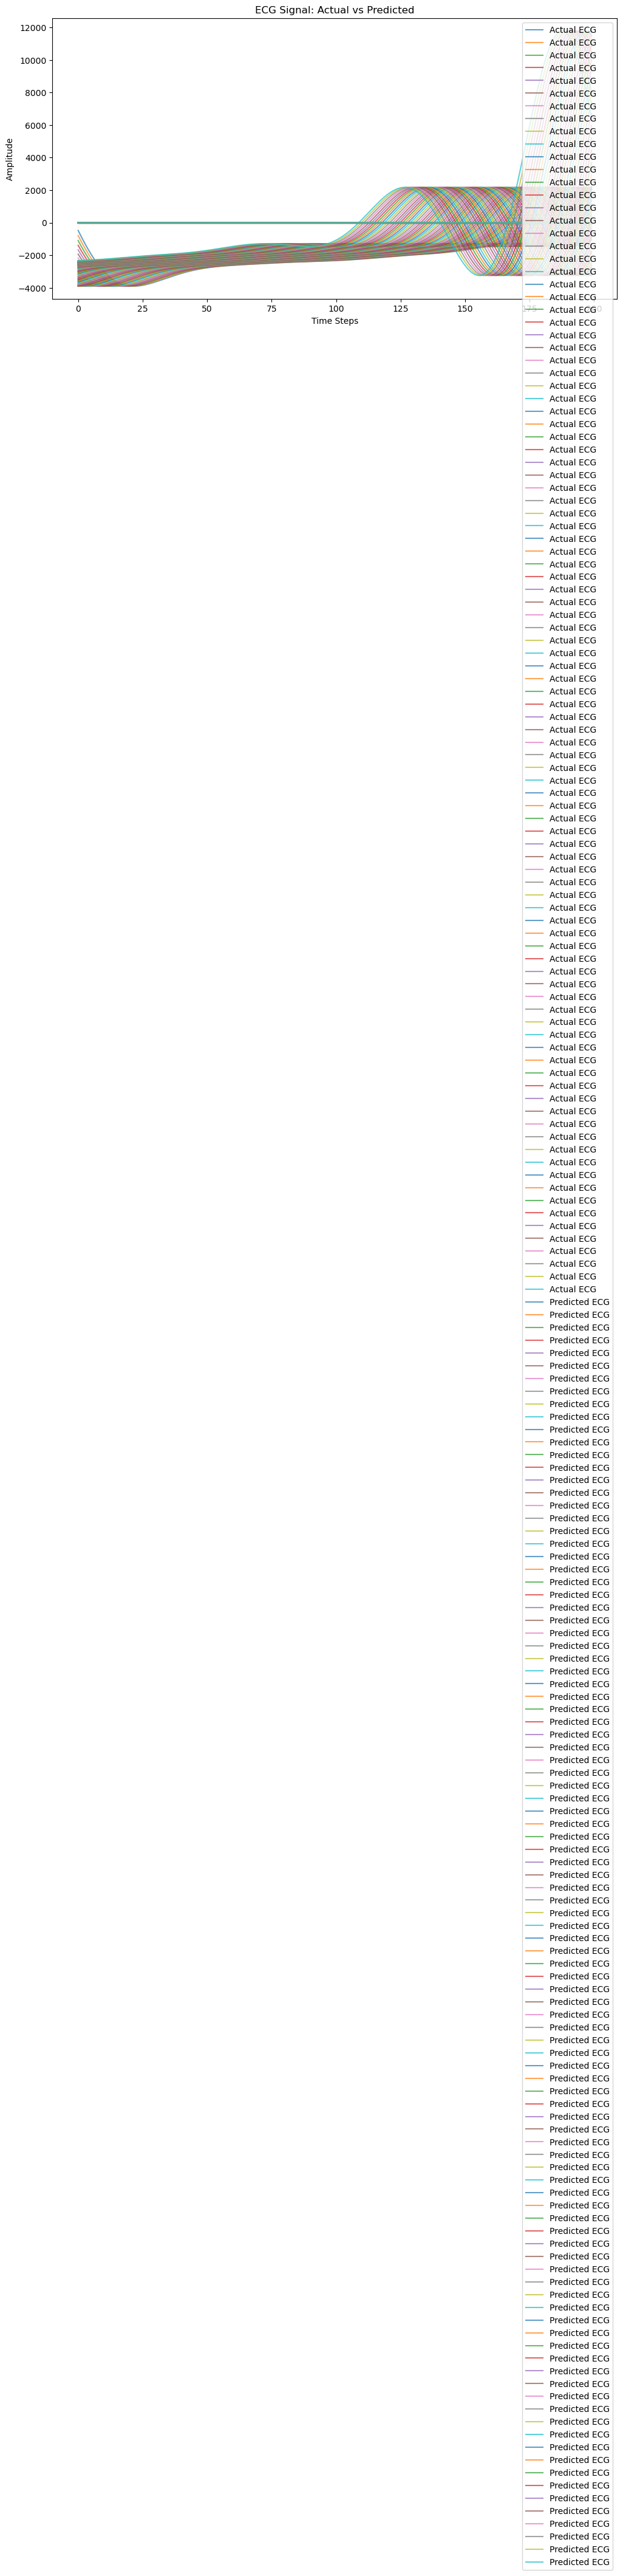

In [26]:
# Ensure both are numpy arrays for plotting
actual_ecg = y_val.squeeze(-1).numpy() if y_val.dim() > 2 else y_val.numpy()
predicted_ecg = ecg_predictions.squeeze(-1).numpy() if ecg_predictions.dim() > 2 else ecg_predictions.numpy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_ecg[:200], label='Actual ECG', alpha=0.7)
plt.plot(predicted_ecg[:200], label='Predicted ECG', alpha=0.7)
plt.title('ECG Signal: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


200


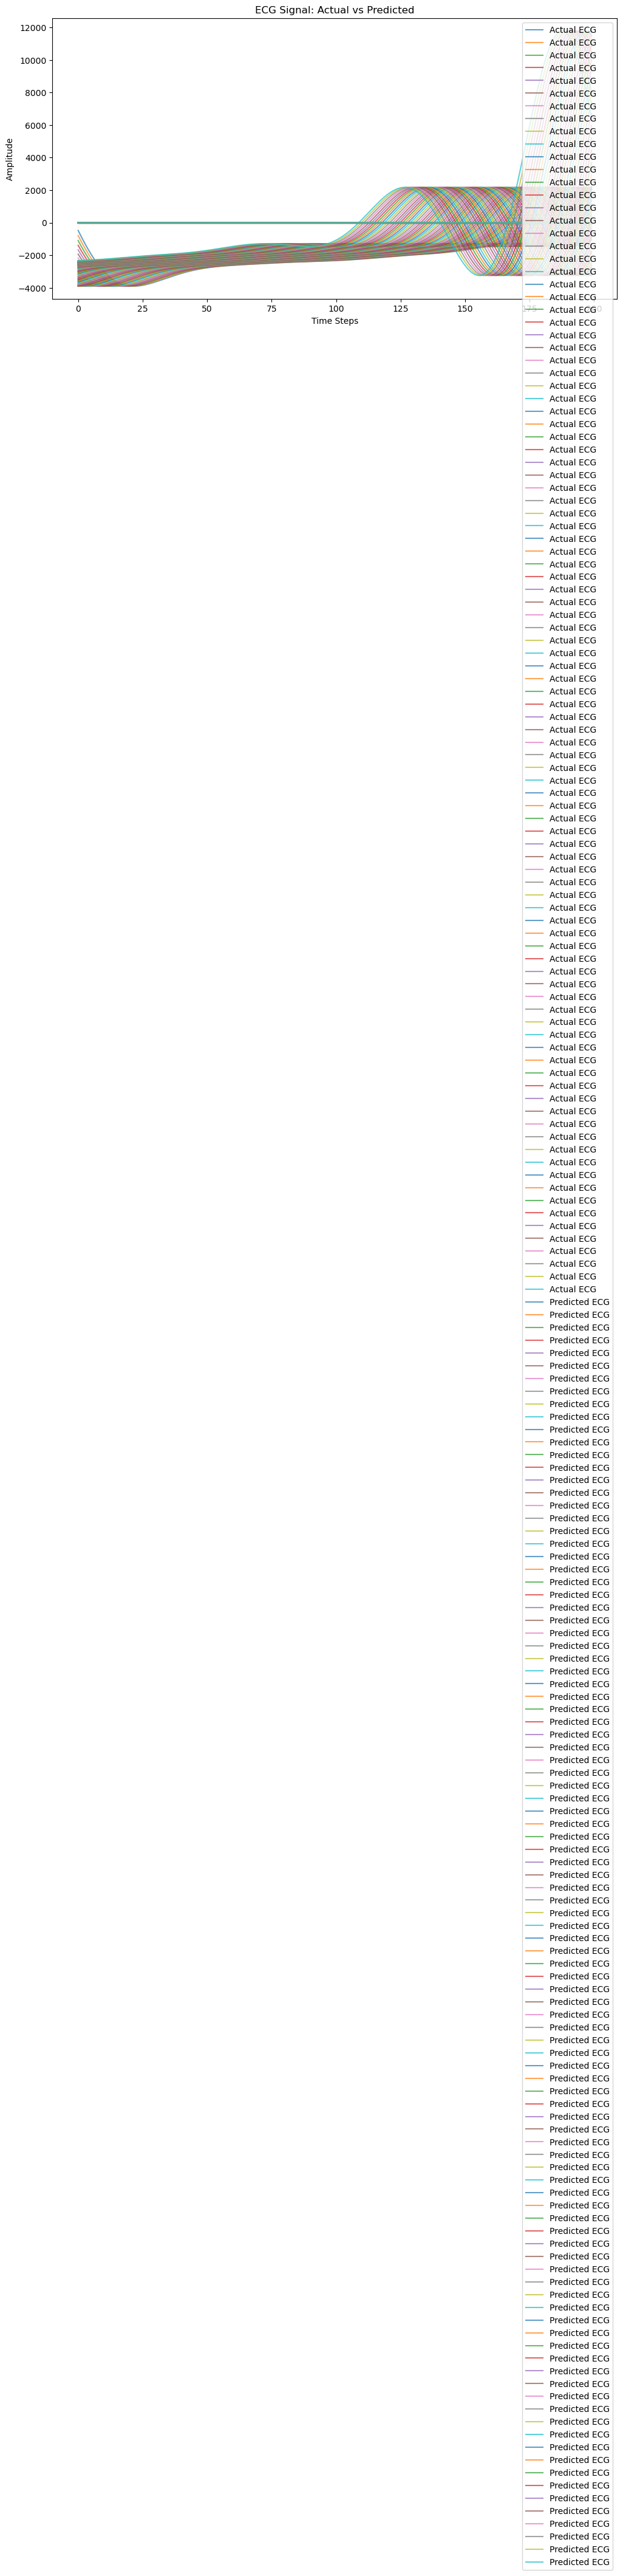

In [25]:
actual_ecg = y_val.squeeze(-1).numpy()  # Squeeze to remove extra dimension
print(len(actual_ecg))
predicted_ecg = ecg_predictions.numpy()

# Example: If actual_ecg has shape [batch_size, sequence_length]
if actual_ecg.shape != predicted_ecg.shape:
    print("Shape mismatch! Adjusting shapes...")
    print("prepredicted_ecg shape before:",predicted_ecg.shape)
    print("actual_ecg shape before:", actual_ecg.shape)

    predicted_ecg =predicted_ecg.squeeze(-1)  # Example adjustment
    actual_ecg = actual_ecg.squeeze(-1)  # Or unsqueeze if needed

    print("prepredicted_ecg shape after:",predicted_ecg.shape)
    print("actual_ecg shape after:", actual_ecg.shape)


# Plot a portion of the sequences (e.g., the first 200 time steps)
plt.figure(figsize=(12, 6))
plt.plot(actual_ecg[:200], label='Actual ECG', alpha=0.7)
plt.plot(predicted_ecg[:200], label='Predicted ECG', alpha=0.7)
plt.title('ECG Signal: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [68]:
actual_ecg

array([[ -471.04428,  -787.94684, -1093.3647 , ..., -2342.711  ,
        -2336.5334 , -2330.0383 ],
       [ -787.94684, -1093.3647 , -1385.9954 , ..., -2336.5334 ,
        -2330.0383 , -2323.1797 ],
       [-1093.3647 , -1385.9954 , -1664.6824 , ..., -2330.0383 ,
        -2323.1797 , -2315.9167 ],
       ...,
       [-1212.8298 , -1144.767  , -1067.234  , ...,  9368.184  ,
         8724.762  ,  8027.0303 ],
       [-1144.767  , -1067.234  ,  -980.0984 , ...,  8724.762  ,
         8027.0303 ,  7283.739  ],
       [-1067.234  ,  -980.0984 ,  -883.33813, ...,  8027.0303 ,
         7283.739  ,  6504.0737 ]], dtype=float32)

In [71]:
type(actual_ecg)

numpy.ndarray

In [55]:
# Normalize actual ECG signal
actual_ecg_normalized = (actual_ecg - actual_ecg.min()) / (actual_ecg.max() - actual_ecg.min())

# Normalize predicted ECG signal
predicted_ecg_normalized = (predicted_ecg - predicted_ecg.min()) / (predicted_ecg.max() - predicted_ecg.min())


In [ ]:
actual_ecg_normalized

<class 'numpy.ndarray'>


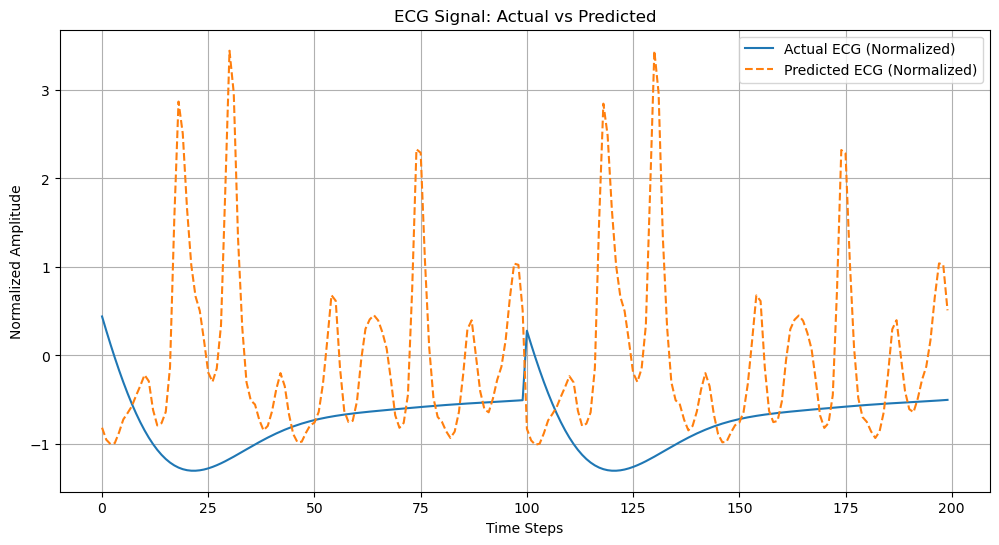

In [70]:
actual_ecg_continuous = actual_ecg_normalized.flatten()
predicted_ecg_continuous = predicted_ecg_normalized.flatten()
print(type(actual_ecg_normalized))

plt.figure(figsize=(12, 6))
plt.plot(actual_ecg_continuous[:200], label='Actual ECG (Normalized)', linestyle='-', linewidth=1.5)
plt.plot(predicted_ecg_continuous[:200], label='Predicted ECG (Normalized)', linestyle='--', linewidth=1.5)
plt.title('ECG Signal: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Standardize (zero mean, unit variance)
actual_ecg_normalized = (actual_ecg - actual_ecg.mean()) / actual_ecg.std()
predicted_ecg_normalized = (predicted_ecg - predicted_ecg.mean()) / predicted_ecg.std()


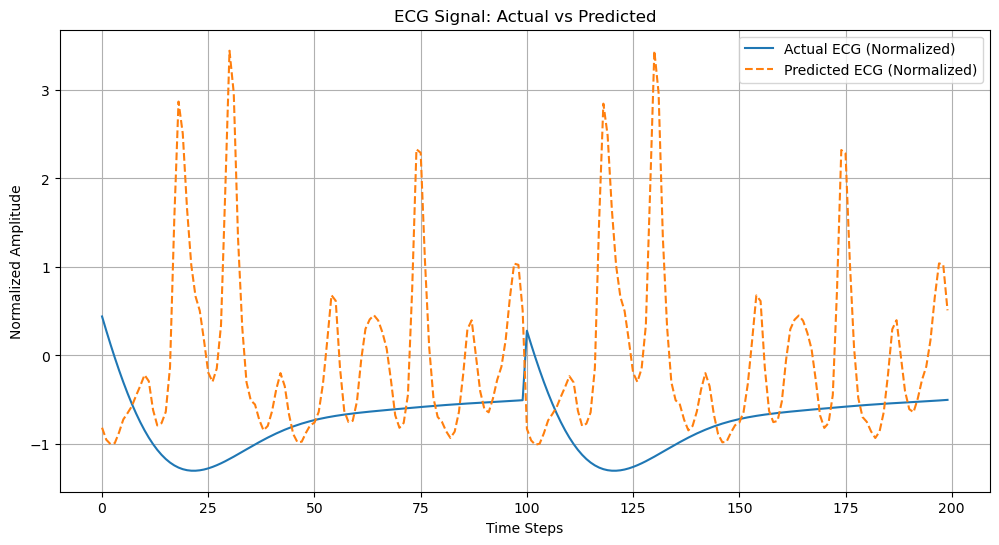

In [60]:
actual_ecg_continuous = actual_ecg_normalized.flatten()
predicted_ecg_continuous = predicted_ecg_normalized.flatten()

plt.figure(figsize=(12, 6))
plt.plot(actual_ecg_continuous[:200], label='Actual ECG (Normalized)', linestyle='-', linewidth=1.5)
plt.plot(predicted_ecg_continuous[:200], label='Predicted ECG (Normalized)', linestyle='--', linewidth=1.5)
plt.title('ECG Signal: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()